<a id='main'></a>
### Functions
[functions](#functions)

### Plots:

[base scencario](#base) 

[close all after one week](#close_all_336) 

[school time separation](#school_times) 

[age dependent interaction modifier Gangelt](#age_dep_IM_G) respective age group's interaction modifier is multiplied by 1.2  others are decreased to remain a mean of 1.0

[age dependent interaction modifier Bad Feilnbach](#age_dep_IM_FB) respective age group's interaction modifier is multiplied by 1.2  others are decreased to remain a mean of 1.0

[homogeneous mixing](#HM) product I*µ= 0.6

[constant product](#prod06) product I*µ= 0.6

[recovered ordered 1](#rw0o1)

[recover from previous infection](#rw1)

[incidence scan LockDownLight_2](#LockDownLight2)


In [1]:
import os
#from VPM_plotting import *
from VPM_plotting_parallel import *
from virusPropagationModel import *

import VPM_plotting as vpm_plot
import get_status_data_and_plots_from_parallel as plt_para
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from functools import partial

%matplotlib inline

In [2]:
color_dict = vpm_plot.scheduleTypeColors

color_dict['underage_0_6'] = color_dict['under_age']
color_dict['underage_6_12'] = color_dict['under_age']
color_dict['underage_12_18'] = color_dict['under_age']

<a id='data_folders'></a>
### Data &  Folders 

In [3]:
#pd.read_excel('/Users/bjorngoldenbogen/Google Drive/Simulations GERDA.gsheet')

In [4]:
server_data_folder_str = '/Volumes/Samsung_T5/corona_simulations/simulation_results_20201028/'
scenarios_list = os.listdir(server_data_folder_str)
scenarios_list.sort()
scenarios_list

['._plot_summary_all_scenarios.pptx',
 'LockDownLight',
 'base_scenario',
 'close_all_336',
 'close_public_home_office_scan_0.2_0.9',
 'close_public_inf_0.15',
 'disobedience_scan_0.00_0.45',
 'incidence_scan_LockDownLight',
 'incidence_scan_LockDownLight_2',
 'incidence_scan_control',
 'incidence_scan_control_2',
 'infect_agents_between_age_20_24',
 'infectivity_scan_0.025_0.500',
 'infectivity_scan_0.05_0.50',
 'infectivity_scan_0.100_0.500',
 'lockdown_start_scan_100_550',
 'mix_base_scenario',
 'mix_product_0.6',
 'modified_interaction_frequencies_Bad_Feilnbach',
 'modified_interaction_frequencies_Gangelt',
 'no_infections',
 'no_infections_mix',
 'plot_summary_all_scenarios.pptx',
 'product_0.6_scan_inf_0.075_1.200',
 'recover_age_scan_0.5_0.9',
 'recover_fromWorld_scan_0.5_0.9',
 'recover_from_world_scan_0.5_0.9',
 'recover_from_world_scan_0.5_0.9_old',
 'recover_household_scan_0.5_0.9',
 'recover_household_scan_0.5_0.9_old',
 'recover_interaction_scan_0.5_0.9',
 'recover_interac

<a id='functions'></a>
### Functions 
[back to top](#main)

In [5]:
def assign_types(agent_id_type_dict, location_id_type_dict, df):
    
    df.sort_values(by='time',inplace=True)
    df['loc_type'] = df['infection_loc_ID'].map(location_id_type_dict)
    df['agent_type'] = df['infected_by_ID'].map(agent_id_type_dict)
    
    return(df)


def get_ID_Type_dicts(scenario, server_data_folder): #
    
    try:
        df_ai = pd.read_csv(server_data_folder+scenario+'/'+scenario[:-10]+'_agent_infos.csv')
        df_li = pd.read_csv(server_data_folder+scenario+'/'+scenario[:-10]+'_location_infos.csv')
    except:
        df_ai = pd.read_csv(server_data_folder+scenario+'/IAR_1_0_99_'+scenario[:-10]+'_agent_infos.csv')
        df_li = pd.read_csv(server_data_folder+scenario+'/IAR_1_0_99_'+scenario[:-10]+'_location_infos.csv')
        
    agent_id_type_dict = dict(zip(df_ai['ID'].values,df_ai['Type'].values))
    location_id_type_dict = dict(zip(df_li['ID'].values,df_li['Type'].values))
    
    return(agent_id_type_dict, location_id_type_dict)   


def get_df_list(scenario, server_data_folder): 
    
    dict_s, dict_l = get_ID_Type_dicts(scenario, server_data_folder)
    infect_info_filenames = os.listdir(server_data_folder+scenario+'/'+'infection_informations/')
    df_list = [pd.read_csv(server_data_folder+scenario+'/'+'infection_informations/'+x) for x in infect_info_filenames]
    mapfunc= partial(assign_types,dict_s, dict_l) #sorted for time
    
    return(list(map(mapfunc, df_list)), dict_s, dict_l)


def get_infections_per_schedule_type(dict_s, df_infection_information, frac=1.0, relative=True):
    
    # world fraction of schedule types
    df_agent_info = pd.DataFrame.from_dict(dict_s,orient='index')
    df_agent_info.reset_index(inplace=True)
    df_agent_info.columns= ['ID','Type']
    df_sc_typ_counts = df_agent_info.groupby('Type').count()['ID']
    
    #infections per type
    if len(df_infection_information)>0:
        df_infection_information['infected_by_type'] = df_infection_information['infected_by_ID'].map(dict_s)
        df_infection_information_mi = add_most_inf(dict_s, df_infection_information, frac=frac)
        df_infection_information_mi_r = df_infection_information_mi[df_infection_information_mi['most_inf']]
        df_sc_typ_counts_inf = df_infection_information_mi_r.groupby('infected_by_type').count()['h_ID']
        
        #spreaders per type
        infectees = df_infection_information_mi_r['infected_by_ID'].unique()
        infectees_st_list = [dict_s[x] for x in  infectees]
        if len(infectees_st_list)>0:
            df_infectees = pd.DataFrame(data=infectees_st_list)
            df_infectees.columns = ['schedule_type']
            df_infectees_st = df_infectees.reset_index(col_fill='count').groupby('schedule_type').count()['index']
        else:
            df_infectees_st = df_sc_typ_counts-df_sc_typ_counts
    else:
        df_sc_typ_counts_inf = df_sc_typ_counts-df_sc_typ_counts
        df_infectees_st = df_sc_typ_counts-df_sc_typ_counts
    
    df_sc_typ_counts_inf = df_sc_typ_counts_inf.add(df_sc_typ_counts-df_sc_typ_counts, fill_value=0)# consider 0 infections
    #df_sc_typ_counts_inf = df_infectees_st.add(df_sc_typ_counts-df_sc_typ_counts, fill_value=0)# consider 0 infections
    
    if relative:
        return(df_sc_typ_counts_inf/df_infectees_st)
    else:
        return(df_sc_typ_counts_inf)


def get_inf_st_combined(df_list, dict_s, **kwargs):
    
    mapfunc = partial(get_infections_per_schedule_type,dict_s, **kwargs)
    inf_st_list = list(map(mapfunc, df_list))
    
    return(pd.concat(inf_st_list, axis=1))
        
    
def get_mean_and_std_inf_st(df_list, dict_s, **kwargs):
    
    df_inf_st_all = get_inf_st_combined(df_list, dict_s, **kwargs)
    df_inf_st_m = df_inf_st_all.mean(axis=1)
    df_inf_st_std= df_inf_st_all.std(axis=1)
    
    return(df_inf_st_m,df_inf_st_std)


def sort_most_infecting_agents(dict_s, df):#
    
    df_group = df.groupby('infected_by_ID').count()['h_ID'].reset_index()
    df_group['type'] = df_group['infected_by_ID'].map(dict_s)
    df_group.columns = ['infected_by_ID','count','agent_type']
    df_group.sort_values('count',ascending=False,inplace=True)
    
    return(df_group)


def add_most_inf(dict_s, df, frac=1):
    
    df_most_inf = sort_most_infecting_agents(dict_s, df)
    list_most_inf_id = df_most_inf[:int(frac*len(df_most_inf))]['infected_by_ID'].values
    df['most_inf'] = df['infected_by_ID'].map(dict(zip(list_most_inf_id,[True]*len(list_most_inf_id))))
    df['most_inf'].fillna(False, inplace=True)
    df_new = df
    
    return(df_new)

# Plots
[back to top](#main)

### test cases

In [11]:
def plot_infections_per_schedule_type(df_inf_st_m,df_inf_st_std, ax):

    df_inf_st_m.plot(kind='bar',color=df_inf_st_m.index.map(color_dict), ax=ax)
    df_inf_st_m_std = df_inf_st_m + df_inf_st_std
    df_inf_st_m_std.plot(kind='bar',color=df_inf_st_m.index.map(color_dict),alpha=0.3, ax=ax)
    ax.grid(which='major', axis='y', linestyle='--', color='grey')#, linewidth=3)
    ax.spines['right'].set_visible(False) 
    ax.spines['top'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.set_xlabel('') 
    ax.set_ylabel('infections per agent')

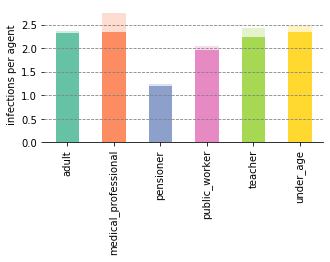

In [170]:
group_folder = 'modified_interaction_frequencies_Gangelt'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = os.listdir(data_folder)
s=subfolder[0]

df_list, dict_s, dict_l = get_df_list(s, data_folder)
df = df_list[0]

df_inf_st_m, df_inf_st_std = get_mean_and_std_inf_st(df_list, dict_s, frac=1.0, relative=True)

fig, ax = plt.subplots(1,1,figsize=(5,2.5))
plot_infections_per_schedule_type(df_inf_st_m,df_inf_st_std, ax)

#mapfunc = partial(get_infections_per_schedule_type,dict_s)
#inf_st_list = list(map(mapfunc, df_list))
#df_inf_st_all = pd.concat(inf_st_list,axis=1)

In [20]:
[x for x in subfolder if x[-5:]!='.pptx']

['parralel_HM_V2_RPM02_hm_Gangelt_big_Ifreq_2_no_mitigation_IF03_None_1.000_ri_1_rx_0']

In [124]:
df_infection_information = df_list[0]
df_agent_info = pd.DataFrame.from_dict(dict_s,orient='index')
df_agent_info.reset_index(inplace=True)
df_agent_info.columns= ['ID','Type']
df_sc_typ_counts = df_agent_info.groupby('Type').count()['ID']

#infections per type schedule 
if len(df_infection_information)>0:
    df_infection_information['infected_by_type'] = df_infection_information['infected_by_ID'].map(dict_s)
    df_infection_information_mi = add_most_inf(dict_s, df_infection_information, frac=0.1)
    df_infection_information_mi_r = df_infection_information_mi[df_infection_information_mi['most_inf']]
    
    df_sc_typ_counts_inf = df_infection_information_mi_r.groupby('infected_by_type').count()['h_ID']  


#spreaders per type
infectees = df_infection_information_mi_r['infected_by_ID'].unique()
df_infectees = pd.DataFrame(data=[dict_s[x] for x in  infectees])
df_infectees.columns = ['schedule_type']
df_infectees_st = df_infectees.reset_index(col_fill='count').groupby('schedule_type').count()['index']
df_infectees_st.sum()
df_sc_typ_counts_inf.sum()/df_infectees_st.sum()

6.170353982300885

In [104]:
infectees = df_infection_information_mi_r['infected_by_ID'].unique()
df_infectees = pd.DataFrame(data=[dict_s[x] for x in  infectees])
df_infectees.columns = ['schedule_type']
df_infectees_st = df_infectees.reset_index(col_fill='count').groupby('schedule_type').count()['index']

In [166]:
inf = get_infections_per_schedule_type(dict_s, df_list[0], frac=0.1, relative=False)
df_infectees = pd.DataFrame(data=[])
df_infectees

""


<a id='base'></a>
### Base Scenario
[back to top](#main)

['parralel_HM_V2_RPM02_hm_Gangelt_big_Ifreq_2_no_mitigation_IF03_None_1.000_ri_1_rx_0', 'parralel_HM_V2_recover_scan_Ifreq_2_no_mitigation_IF03_None_1.000_ri_1_rx_0']


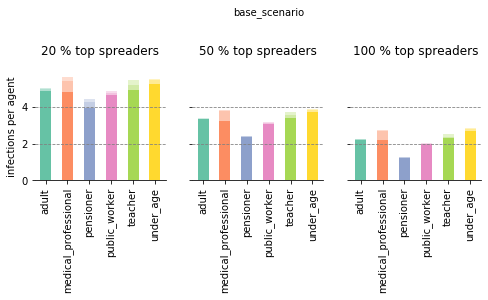

In [14]:
group_folder = 'base_scenario' ## IM *1.2
data_folder = server_data_folder_str+group_folder +'/'
subfolder = [x for x in os.listdir(data_folder) if x[-5:]!='.pptx']
subfolder.sort()
print(subfolder)
#titles = ['0-24 ','25-49', '50-74','75-99']

fig, axes = plt.subplots(1,3,figsize=(8,2.0), sharex=True, sharey=True)

axes[1].text(3, 9, group_folder,  horizontalalignment='center')

for k,s in enumerate(subfolder):
 
    df_list, dict_s, dict_l = get_df_list(s, data_folder)
    
    for i,frac in enumerate([0.2,0.5,1.0]):
        
        df_inf_st_m, df_inf_st_std = get_mean_and_std_inf_st(df_list, dict_s, frac=frac, relative=True)
        plot_infections_per_schedule_type(df_inf_st_m,df_inf_st_std, axes[i])
        axes[i].set_title(str(int(frac*100))+' % top spreaders', y=1.1)
        #axes[0].text(-3,0, titles[k], rotation=90, verticalalignment='center')

    
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.png', bbox_inches='tight') 
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.svg', bbox_inches='tight')     

Text(0.5, 0, '')

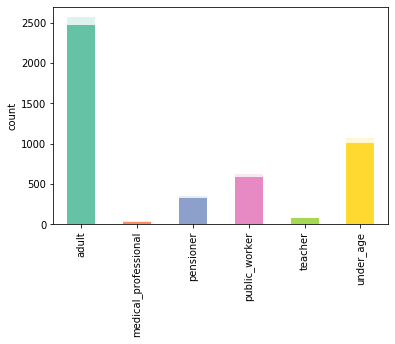

In [86]:
df_combined = pd.concat(df_list_2,axis=1) 
df_c_m = df_combined.mean(axis=1)
df_c_std = df_combined.std(axis=1)
df_c_m.plot(kind='bar', color=df_inf_per_schedule_type.index.map(color_dict))
df_std_m = df_c_m+df_c_std
df_std_m.plot(kind='bar', color=df_inf_per_schedule_type.index.map(color_dict),alpha=0.2)
plt.ylabel('count')
plt.xlabel('')

<a id='close_all_336'></a>
### Close All after one week
[back to top](#main)

['parralel_HM_V2_RPM02_hm_Gangelt_big_Ifreq_2_close_all_IF03_None_1.000_ri_1_rx_0']


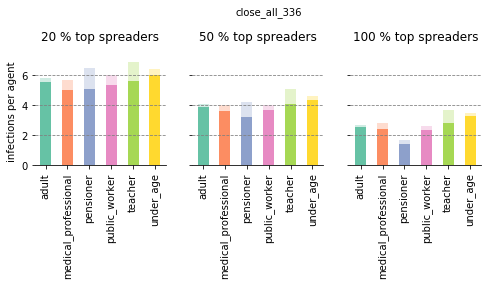

In [144]:
group_folder = 'close_all_336' ## IM *1.2
data_folder = server_data_folder_str+group_folder +'/'
subfolder = [x for x in os.listdir(data_folder) if (x[-5:]!='.pptx')and(x[1]!='.')]
subfolder.sort()
print(subfolder)
#titles = ['0-24 ','25-49', '50-74','75-99']

fig, axes = plt.subplots(len(subfolder),3,figsize=(8,len(subfolder)*2.0), sharex=True, sharey=True)

axes[1].text(3, 10, group_folder,  horizontalalignment='center')

for k,s in enumerate(subfolder):
 
    df_list, dict_s, dict_l = get_df_list(s, data_folder)
    
    for i,frac in enumerate([0.2,0.5,1.0]):
        
        df_inf_st_m, df_inf_st_std = get_mean_and_std_inf_st(df_list, dict_s, frac=frac)
        plot_infections_per_schedule_type(df_inf_st_m,df_inf_st_std, axes[i])
        axes[i].set_title(str(int(frac*100))+' % top spreaders', y=1.1)
        #axes[0].text(-3,0, titles[k], rotation=90, verticalalignment='center')

    
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.png', bbox_inches='tight') 
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.svg', bbox_inches='tight')     

<a id='school_times'></a>
### School time separation
[back to top](#main)

['parralel_HM_V2_different_school_times_2nd_attempt_Ifreq_2_no_mitigation_IF03_None_1.000_ri_1_rx_0']


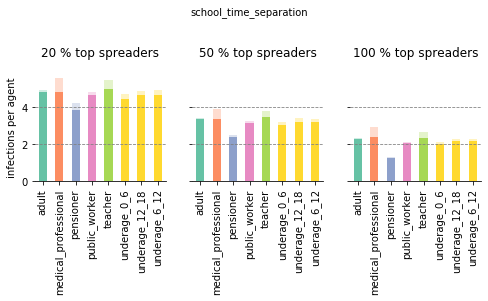

In [151]:
group_folder = 'school_time_separation' ## IM *1.2
data_folder = server_data_folder_str+group_folder +'/'
subfolder = [x for x in os.listdir(data_folder) if (x[-5:]!='.pptx')and(x[1]!='.')]
subfolder.sort()
print(subfolder)
#titles = ['0-24 ','25-49', '50-74','75-99']

fig, axes = plt.subplots(len(subfolder),3,figsize=(8,len(subfolder)*2.0), sharex=True, sharey=True)

axes[1].text(3, 9, group_folder,  horizontalalignment='center')

for k,s in enumerate(subfolder):
 
    df_list, dict_s, dict_l = get_df_list(s, data_folder)
    
    for i,frac in enumerate([0.2,0.5,1.0]):
        
        df_inf_st_m, df_inf_st_std = get_mean_and_std_inf_st(df_list, dict_s, frac=frac)
        plot_infections_per_schedule_type(df_inf_st_m,df_inf_st_std, axes[i])
        axes[i].set_title(str(int(frac*100))+' % top spreaders', y=1.1)
        #axes[0].text(-3,0, titles[k], rotation=90, verticalalignment='center')

    
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.png', bbox_inches='tight') 
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.svg', bbox_inches='tight')     

<a id='HM'></a>
### Homogeneous Mixing
Product of Infectivity and µ = 0.6

[back to top](#main)

['mix_parralel_HM_V2_RPM02_hm_Gangelt_big_no_mitigation_IF03_prod_0.6_inf_0.075_mu_8.000_ri_1_rx_0', 'mix_parralel_HM_V2_RPM02_hm_Gangelt_big_no_mitigation_IF03_prod_0.6_inf_0.300_mu_2.000_ri_1_rx_0', 'mix_parralel_HM_V2_RPM02_hm_Gangelt_big_no_mitigation_IF03_prod_0.6_inf_1.200_mu_0.500_ri_1_rx_0']


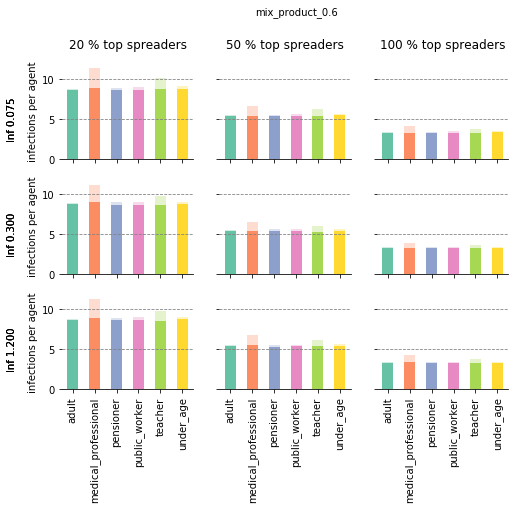

In [192]:
group_folder = 'mix_product_0.6'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = [x for x in os.listdir(data_folder) if (x[-5:]!='.pptx')and(x[1]!='.')]
subfolder.sort()
print(subfolder)

fig, axes = plt.subplots(len(subfolder),3,figsize=(8,len(subfolder)*2.0), sharex=True, sharey=True)

axes[0][1].text(3,18, group_folder,  horizontalalignment='center')

for k,s in enumerate(subfolder):
 
    df_list, dict_s, dict_l = get_df_list(s, data_folder)
    
    for i,frac in enumerate([0.2,0.5,1.0]):
        
        df_inf_st_m, df_inf_st_std = get_mean_and_std_inf_st(df_list, dict_s, frac=frac)
        plot_infections_per_schedule_type(df_inf_st_m,df_inf_st_std, axes[k][i])
        axes[0][i].set_title(str(int(frac*100))+' % top spreaders', y=1.1)
        axes[k][0].text(-3,5, 'Inf {}'.format(s.split('_')[-7]), rotation=90, verticalalignment='center')

plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.png', bbox_inches='tight') 
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.svg', bbox_inches='tight')     

<a id='prod06'></a>
### Product of Infectivity and µ = 0.6
[back to top](#main)

['parralel_HM_V2_RPM02_hm_Gangelt_big_no_mitigation_IF03_prod_0.6_inf_0.075_ri_1_rx_0', 'parralel_HM_V2_RPM02_hm_Gangelt_big_no_mitigation_IF03_prod_0.6_inf_0.300_ri_1_rx_0', 'parralel_HM_V2_RPM02_hm_Gangelt_big_no_mitigation_IF03_prod_0.6_inf_1.200_ri_1_rx_0']


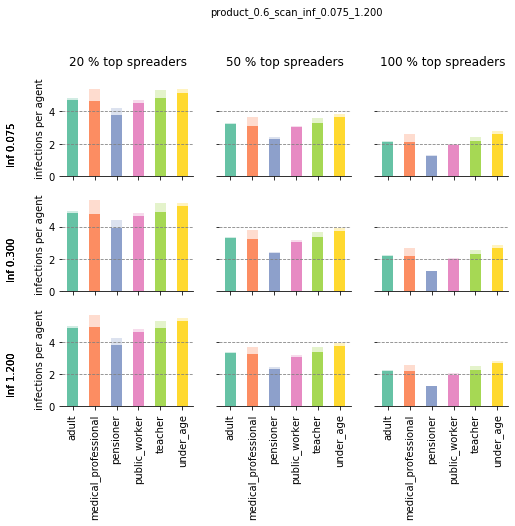

In [188]:
group_folder = 'product_0.6_scan_inf_0.075_1.200'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = [x for x in os.listdir(data_folder) if (x[-5:]!='.pptx')and(x[1]!='.')]
subfolder.sort()
print(subfolder)

fig, axes = plt.subplots(len(subfolder),3,figsize=(8,len(subfolder)*2.0), sharex=True, sharey=True)

axes[0][1].text(3,10, group_folder,  horizontalalignment='center')

for k,s in enumerate(subfolder):
 
    df_list, dict_s, dict_l = get_df_list(s, data_folder)
    
    for i,frac in enumerate([0.2,0.5,1.0]):
        
        df_inf_st_m, df_inf_st_std = get_mean_and_std_inf_st(df_list, dict_s, frac=frac)
        plot_infections_per_schedule_type(df_inf_st_m,df_inf_st_std, axes[k][i])
        axes[0][i].set_title(str(int(frac*100))+' % top spreaders', y=1.1)
        axes[k][0].text(-3,2, 'Inf {}'.format(s.split('_')[-5]), rotation=90, verticalalignment='center')

plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.png', bbox_inches='tight') 
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.svg', bbox_inches='tight')     

<a id='rw0o1'></a>
### Recovered ordered 1 
[back to top](#main)

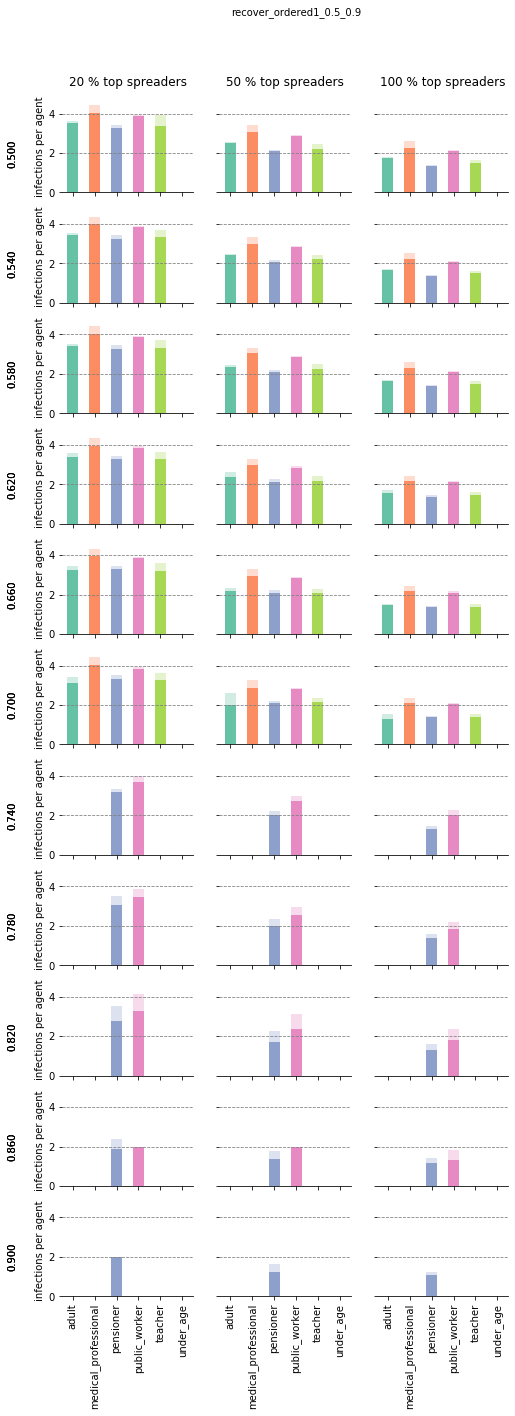

In [189]:
group_folder = 'recover_ordered1_0.5_0.9'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = [x for x in os.listdir(data_folder) if (x[-5:]!='.pptx')and(x[1]!='.')]
subfolder.sort()

fig, axes = plt.subplots(len(subfolder),3,figsize=(8,len(subfolder)*2.0), sharex=True, sharey=True)

axes[0][1].text(3,9, group_folder,  horizontalalignment='center')

for k,s in enumerate(subfolder):
 
    df_list, dict_s, dict_l = get_df_list(s, data_folder)
    
    for i,frac in enumerate([0.2,0.5,1.0]):
        
        df_inf_st_m, df_inf_st_std = get_mean_and_std_inf_st(df_list, dict_s, frac=frac)
        plot_infections_per_schedule_type(df_inf_st_m,df_inf_st_std, axes[k][i])
        axes[0][i].set_title(str(int(frac*100))+' % top spreaders', y=1.1)
        axes[k][0].text(-3,2, s.split('_')[-7], rotation=90, verticalalignment='center')
    
    
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.png', bbox_inches='tight') 
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.svg', bbox_inches='tight')     

<a id='IFS'></a>
### infectivity_scan_0.100_0.500
[back to top](#main)

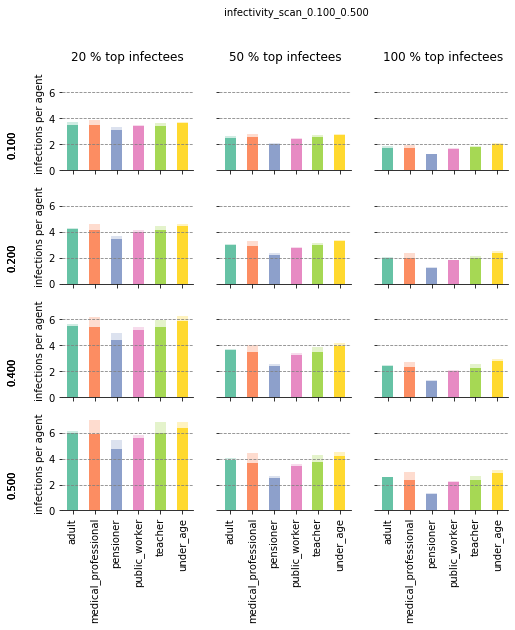

In [190]:
group_folder = 'infectivity_scan_0.100_0.500'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = [x for x in os.listdir(data_folder) if (x[-5:]!='.pptx')and(x[1]!='.')]
subfolder.sort()

fig, axes = plt.subplots(len(subfolder),3,figsize=(8,len(subfolder)*2.0), sharex=True, sharey=True)

axes[0][1].text(3,12, group_folder,  horizontalalignment='center')

for k,s in enumerate(subfolder):
 
    df_list, dict_s, dict_l = get_df_list(s, data_folder)
    
    for i,frac in enumerate([0.2,0.5,1.0]):
        
        df_inf_st_m, df_inf_st_std = get_mean_and_std_inf_st(df_list, dict_s, frac=frac)
        plot_infections_per_schedule_type(df_inf_st_m,df_inf_st_std, axes[k][i])
        axes[0][i].set_title(str(int(frac*100))+' % top infectees', y=1.1)
        axes[k][0].text(-3,2, s.split('_')[-5], rotation=90, verticalalignment='center')

    
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.png', bbox_inches='tight') 
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.svg', bbox_inches='tight')     

<a id='#age_dep_IM_FB'></a>
### modified interaction per age group frequencies Bad_Feilnbach 
[back to top](#main)

['IAR_1.2_0.0_24.0_parralel_HM_V2_Bad_Feilnbach_Ifreq_2_no_mitigation_IF03_None_1.000_ri_1_rx_0', 'IAR_1.2_25.0_49.0_parralel_HM_V2_Bad_Feilnbach_Ifreq_2_no_mitigation_IF03_None_1.000_ri_1_rx_0', 'IAR_1.2_50.0_74.0_parralel_HM_V2_Bad_Feilnbach_Ifreq_2_no_mitigation_IF03_None_1.000_ri_1_rx_0', 'IAR_1.2_75.0_99.0_parralel_HM_V2_Bad_Feilnbach_Ifreq_2_no_mitigation_IF03_None_1.000_ri_1_rx_0']


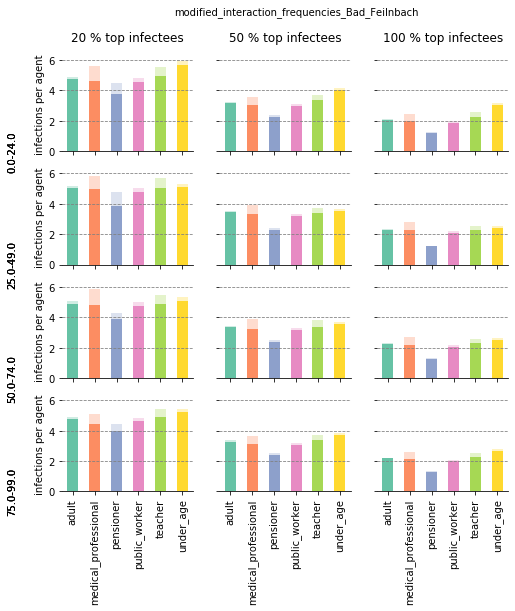

In [173]:
group_folder = 'modified_interaction_frequencies_Bad_Feilnbach' ## IM *1.2
data_folder = server_data_folder_str+group_folder +'/'
subfolder = [x for x in os.listdir(data_folder) if (x[-5:]!='.pptx')and(x[1]!='.')]
subfolder.sort()
print(subfolder)

fig, axes = plt.subplots(len(subfolder),3,figsize=(8,len(subfolder)*2.0), sharex=True, sharey=True)

axes[0][1].text(3,9, group_folder,  horizontalalignment='center')

for k,s in enumerate(subfolder):
 
    df_list, dict_s, dict_l = get_df_list(s, data_folder)
    
    for i,frac in enumerate([0.2,0.5,1.0]):
        
        df_inf_st_m, df_inf_st_std = get_mean_and_std_inf_st(df_list, dict_s, frac=frac)
        plot_infections_per_schedule_type(df_inf_st_m,df_inf_st_std, axes[k][i])
        axes[0][i].set_title(str(int(frac*100))+' % top infectees', y=1.1)
        axes[k][0].text(-3,3, s.split('_')[2]+'-'+s.split('_')[3], rotation=90, verticalalignment='center')

    
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.png', bbox_inches='tight') 
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.svg', bbox_inches='tight')  

<a id='age_dep_IM'></a>
### Age dependent increase of interaction modifier by 1.2 Gangelt
[back to top](#main)

['IAR_1.2_0.0_24.0_parralel_HM_V2_Ifreq_2_no_mitigation_IF03_None_1.000_ri_1_rx_0', 'IAR_1.2_25.0_49.0_parralel_HM_V2_Ifreq_2_no_mitigation_IF03_None_1.000_ri_1_rx_0', 'IAR_1.2_50.0_74.0_parralel_HM_V2_Ifreq_2_no_mitigation_IF03_None_1.000_ri_1_rx_0', 'IAR_1.2_75.0_99.0_parralel_HM_V2_Ifreq_2_no_mitigation_IF03_None_1.000_ri_1_rx_0']


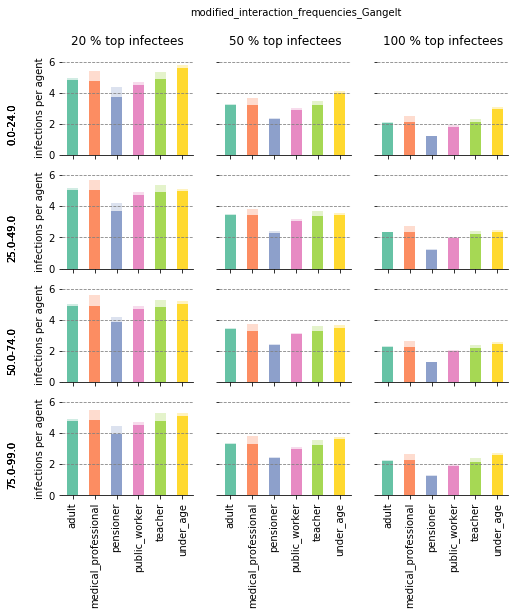

In [191]:
group_folder = 'modified_interaction_frequencies_Gangelt' ## IM *1.2
data_folder = server_data_folder_str+group_folder +'/'
subfolder = [x for x in os.listdir(data_folder) if (x[-5:]!='.pptx')and(x[1]!='.')]
subfolder.sort()
print(subfolder)

fig, axes = plt.subplots(len(subfolder),3,figsize=(8,len(subfolder)*2.0), sharex=True, sharey=True)

axes[0][1].text(3,9, group_folder,  horizontalalignment='center')

for k,s in enumerate(subfolder):
 
    df_list, dict_s, dict_l = get_df_list(s, data_folder)
    
    for i,frac in enumerate([0.2,0.5,1.0]):
        
        df_inf_st_m, df_inf_st_std = get_mean_and_std_inf_st(df_list, dict_s, frac=frac)
        plot_infections_per_schedule_type(df_inf_st_m,df_inf_st_std, axes[k][i])
        axes[0][i].set_title(str(int(frac*100))+' % top infectees', y=1.1)
        axes[k][0].text(-3,3, s.split('_')[2]+'-'+s.split('_')[3], rotation=90, verticalalignment='center')

    
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.png', bbox_inches='tight') 
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.svg', bbox_inches='tight')     

<a id='LockDownLight2'></a>
### incidence scan LockDownLight_2
[back to top](#main)

['Gangelt_dst_incidence_testing_Ifreq_2_close_public_reopen_IF03_None_1.000_ri_1_rx_0', 'Linsengericht_dst_incidence_testing_Ifreq_2_close_public_reopen_IF03_None_1.000_ri_1_rx_0', 'Oranienbaum_dst_incidence_testing_Ifreq_2_close_public_reopen_IF03_None_1.000_ri_1_rx_0', 'Simbach_dst_incidence_testing_Ifreq_2_close_public_reopen_IF03_None_1.000_ri_1_rx_0']


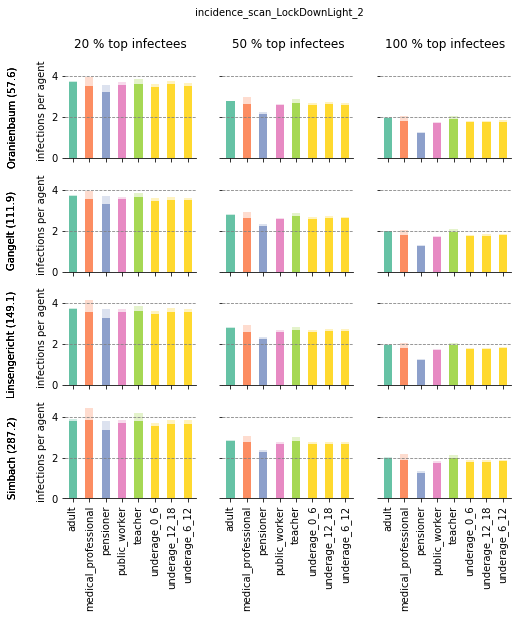

In [204]:
group_folder = 'incidence_scan_LockDownLight_2'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = [x for x in os.listdir(data_folder) if (x[-5:]!='.pptx')and(x[1]!='.')]
subfolder.sort()
print(subfolder)

inzidince_dict = { 'Oranienbaum': 57.6,
                   'Gangelt': 111.9,
                   'Linsengericht': 149.1,
                    'Simbach': 287.2, }

fig, axes = plt.subplots(len(subfolder),3,figsize=(8,len(subfolder)*2.0), sharex=True, sharey=True)

axes[0][1].text(3,7, group_folder,  horizontalalignment='center')

for k,town in enumerate(inzidince_dict):
    s = town +'_dst_incidence_testing_Ifreq_2_close_public_reopen_IF03_None_1.000_ri_1_rx_0'
    df_list, dict_s, dict_l = get_df_list(s, data_folder)
    
    for i,frac in enumerate([0.2,0.5,1.0]):
        
        df_inf_st_m, df_inf_st_std = get_mean_and_std_inf_st(df_list, dict_s, frac=frac)
        plot_infections_per_schedule_type(df_inf_st_m,df_inf_st_std, axes[k][i])
        axes[0][i].set_title(str(int(frac*100))+' % top infectees', y=1.1)
        axes[k][0].text(-4,2, '{} ({})'.format(town, inzidince_dict[town]), rotation=90, verticalalignment='center')

    
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.png', bbox_inches='tight') 
plt.savefig('plots/fig_'+group_folder+'_inf_per_schedule_type.svg', bbox_inches='tight') 